In [4]:
import random

import networkx as nx
import numpy as np
import osmnx as ox
from tqdm import trange, tqdm

In [5]:
# Statistic for all-pair-paths between points of two clusters
def get_statistic_per_point(graph: nx.Graph, c_from: int, c_to: int, _cls2hubs: dict[int:set[int]], log=False):
    nodes_from = _cls2hubs[c_from]
    nodes_to = _cls2hubs[c_to]
    statistic = {}
    generator = tqdm(nodes_from, desc='find statistic') if log else nodes_from
    for f in generator:
        statistic[f] = {}
        for t in nodes_to:
            p = nx.single_source_dijkstra(graph, f, t, weight='length')
            cls = list(dict.fromkeys([int(graph.nodes()[u]['cluster']) for u in p[1]]))
            cls = tuple(cls)
            if cls not in statistic[f]:
                statistic[f][cls] = 0
            statistic[f][cls] += 1
    return statistic

In [6]:
# cluster to neighboring clusters
def get_cls2n(graph: nx.Graph) -> dict[int: set[int]]:
    _cls2n = {}
    for u, du in graph.nodes(data=True):
        for v in graph[u]:
            dv = graph.nodes()[v]
            if dv['cluster'] == du['cluster']:
                continue
            c1 = dv['cluster']
            c2 = du['cluster']
            if not (c1 in _cls2n):
                _cls2n[c1] = set()
            if not (c2 in _cls2n):
                _cls2n[c2] = set()
            _cls2n[c1].add(c2)
            _cls2n[c2].add(c1)
    return _cls2n


# cluster then yts point that are connected with neighboring clusters
def get_cls2hubs(graph: nx.Graph) -> dict[int: set[int]]:
    _cls2hubs = {}
    for u, du in graph.nodes(data=True):
        for v in graph[u]:
            dv = graph.nodes()[v]
            c1 = du['cluster']
            c2 = dv['cluster']
            if c1 == c2:
                continue
            if not (c1 in _cls2hubs):
                _cls2hubs[c1] = set()
            if not (c2 in _cls2hubs):
                _cls2hubs[c2] = set()
            _cls2hubs[c1].add(u)
            _cls2hubs[c2].add(v)
    return _cls2hubs


# adjacency matrix. it contain clusters that intersect with paths between two clusters
def get_ad_matrix(
        graph: nx.Graph,
        communities: list[set[int]],
        cls2hubs,
        cls2n
) -> dict[int: dict[int:set[int]]]:
    ad_matrix = {}
    for i in trange(0, len(communities)):
        ad_matrix[i] = {}
        for j in cls2n[i]:
            data = get_statistic_per_point(graph, i, j, cls2hubs, False)
            ss = set()
            for k, v in data.items():
                for kk, vv in v.items():
                    ss.add(kk)
            cls0to1 = set()
            for ii in ss:
                for jj in ii:
                    cls0to1.add(jj)
            ad_matrix[i][j] = cls0to1
    return ad_matrix


# build_center_graph
def build_center_graph(
        graph: nx.Graph,
        communities: list[set[int]],
        adjacency: dict[int:dict[int, set[int]]],
        cls2n: dict[int: set[int]]
) -> tuple[nx.Graph, dict[int, int]]:
    """
        строим граф центройд по комьюнити для графа G
    """
    x_graph = nx.Graph()
    cls2c = {}
    for cls, _ in enumerate(communities):
        gc = extract_cluster_list_subgraph(graph, [cls], communities)
        min_node = nx.barycenter(gc, weight='length')[0]
        du = graph.nodes()[min_node]
        x_graph.add_node(graph.nodes()[min_node]['cluster'], **du)
        cls2c[graph.nodes()[min_node]['cluster']] = min_node

    if len(x_graph.nodes) == 1:
        return x_graph, cls2c

    for u in x_graph.nodes():
        for v in cls2n[u]:
            g = extract_cluster_list_subgraph(graph, adjacency[u][v], communities)
            l = nx.single_source_dijkstra(g, source=cls2c[u], target=cls2c[v], weight='length')[0]
            x_graph.add_edge(u, v, length=l)
    return x_graph, cls2c


In [7]:
#load graph
def get_graph(city_id: str = 'R2555133') -> nx.Graph:
    gdf = ox.geocode_to_gdf(city_id, by_osmid=True)
    polygon_boundary = gdf.unary_union
    graph = ox.graph_from_polygon(polygon_boundary,
                                  network_type='drive',
                                  simplify=True)
    G = nx.Graph(graph)
    H = nx.Graph()
    # Добавляем рёбра в новый граф, копируя только веса
    for u, d in G.nodes(data=True):
        H.add_node(u, x=d['x'], y=d['y'])
    for u, v, d in G.edges(data=True):
        if u == v:
            continue
        H.add_edge(u, v, length=d['length'])
    del city_id, gdf, polygon_boundary, graph, G
    return H


#extract subgraph by clusters
def extract_cluster_list_subgraph(graph: nx.Graph, cluster_number: list[int] | set[int], communities=None) -> nx.Graph:
    if communities:
        nodes_to_keep = [u for c in cluster_number for u in communities[c]]
    else:
        nodes_to_keep = [node for node, data in graph.nodes(data=True) if data['cluster'] in cluster_number]
    return graph.subgraph(nodes_to_keep)


#resolve_communities
def resolve_communities(H: nx.Graph, **params) -> list[set[int]]:
    communities = nx.community.louvain_communities(H,
                                                   seed=1534,
                                                   weight='length',
                                                   resolution=params['r'])
    cls = []
    for i, c in enumerate(communities):
        for n in nx.connected_components(H.subgraph(c)):
            cls.append(n)
    for i, ids in enumerate(cls):
        for j in ids:
            H.nodes()[j]['cluster'] = i
    return cls

Path Finding Alg

In [8]:
# find path between two points
def find_path_length_h(
        g0: nx.Graph,
        g1: nx.Graph,
        adjacency: dict[int, dict[int:set[int]]],
        cms: list[set[int]] | tuple[set[int]],
        cls2c: dict[int:int],
        from_node: int,
        to_node: int,
        cls2n: dict[int, set[int]]) -> float:
    from_cluster = g0.nodes()[from_node]['cluster']
    to_cluster = g0.nodes()[to_node]['cluster']

    path = nx.single_source_dijkstra(g1, from_cluster, to_cluster, weight='length')[1]
    cls = set()
    cls.add(to_cluster)
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]
        cu = g0.nodes()[cls2c[u]]['cluster']
        cv = g0.nodes()[cls2c[v]]['cluster']
        for c in adjacency[cu][cv]:
            cls.add(c)
        cls.add(cu)
        cls.add(cv)
    g = extract_cluster_list_subgraph(g0, cls, cms)
    return nx.single_source_dijkstra(g, from_node, to_node, weight='length')


In [9]:
g = get_graph('R2555133')

In [10]:
cms = resolve_communities(g, r=10)
print(len(cms))

504


In [11]:
cls2n = get_cls2n(g)
cls2hubs = get_cls2hubs(g)

In [12]:
for u, du in g[12035249578].items():
    # du = g.nodes()[u]
    print(u, du)
print(g[12035249578])

332002257 {'length': 46.84}
339588494 {'length': 123.86099999999999}
12035249579 {'length': 34.846000000000004}
{332002257: {'length': 46.84}, 339588494: {'length': 123.86099999999999}, 12035249579: {'length': 34.846000000000004}}


In [13]:
ad_mat = get_ad_matrix(g, cms, cls2hubs, cls2n)

100%|██████████| 504/504 [16:20<00:00,  1.95s/it] 


In [14]:
print(cls2hubs[0])

{5099434656, 1154292258, 3473539717, 264162534, 307620185, 148620201, 3660079849, 81377003, 38441229, 111911986, 988505398, 81355640, 71061625, 3733681049, 303224956, 1153119326}


In [15]:
g1, cls2c = build_center_graph(g, cms, ad_mat, cls2n)

In [25]:
def get_node_for_initial_graph_v2(graph: nx.Graph):
    nodes = list(graph.nodes())
    f, t = random.choice(nodes), random.choice(nodes)
    while f == t:
        f, t = random.choice(nodes), random.choice(nodes)
    return f, t


points = [get_node_for_initial_graph_v2(g) for _ in trange(1_000, desc='generate points')]

generate points: 100%|██████████| 1000/1000 [00:00<00:00, 5247.86it/s]


In [19]:
# print(g1.edges[(988, 1121)])

KeyError: 'The edge (988, 1121) is not in the graph.'

In [26]:
stat = {}
stat['l'] = []
stat['h_l'] = []
stat['p'] = []
stat['h_p'] = []
stat['delta'] = []
for p1, p2 in tqdm(points, desc='find paths'):
    if (p1, p2) in stat:
        continue
    l, p = nx.single_source_dijkstra(g, p1, p2, weight='length')
    h_l, h_p = find_path_length_h(g, g1, ad_mat, cms, cls2c, p1, p2, cls2n)
    delta = (h_l - l) / l * 100
    stat['l'].append(l)
    stat['h_l'].append(h_l)
    stat['p'].append(p)
    stat['h_p'].append(h_p)
    stat['delta'].append(delta)
    # tqdm.write(f"""delta: {delta:.4f}%, l: {l:.2f}, hl: { h_l:.2f}""")

find paths: 100%|██████████| 1000/1000 [01:08<00:00, 14.52it/s]


In [21]:
print('err_mean:', np.mean(stat['delta']))
print('err_min:', np.min(stat['delta']))
print('err_max:', np.max(stat['delta']))

err_mean: 1.752465965822053
err_min: 0.0
err_max: 48.30613801365602


In [ ]:
import folium

In [ ]:
def get_color_list(l: int):
    cmap = plt.get_cmap('plasma')
    colors = [cmap(i / l) for i in range(l)]
    hex_colors = ['#' + ''.join([f'{int(c * 255):02x}' for c in color[:3]]) \
                  for color in colors]
    return hex_colors


def draw_on_map(_g: nx.Graph,
                communities: tuple = None,
                m: folium.Map = None,
                node_colors: list | str = None,
                edge_colors: str = 'black') -> folium.Map:
    if communities is None:
        communities = _g.nodes
    if node_colors is None:
        node_colors = get_color_list(len(communities))

    if m is None:
        for u, d in _g.nodes(data=True):
            u_x, u_y = d['x'], d['y']
            break
        m = folium.Map(location=[u_y, u_x], zoom_start=10)  # Координаты города
    for i, community in enumerate(communities):
        for node in community:
            if node not in _g.nodes():
                continue
            node_data = _g.nodes[node]
            popup_text = f"Кластер: {i}, \n" + f"номер: {node}"
            folium.CircleMarker(
                location=(node_data['y'], node_data['x']),
                radius=4,
                color=node_colors[i] if isinstance(node_colors, list) else node_colors,
                fill=True,
                fill_color=node_colors[i] if isinstance(node_colors, list) is list else node_colors,
                fill_opacity=0.7,
                popup=popup_text
            ).add_to(m)
    if not (edge_colors is None):
        for u, v, data in _g.edges(data=True):
            u_x, u_y = _g.nodes()[u]['x'], _g.nodes()[u]['y']
            v_x, v_y = _g.nodes()[v]['x'], _g.nodes()[v]['y']
            folium.PolyLine([(u_y, u_x), (v_y, v_x)], color=edge_colors, weight=1).add_to(m)
    return m

In [27]:
max_index = np.argmax(stat['delta'])
correct_path = g.subgraph(stat['p'][max_index])
h_path = g.subgraph(stat['h_p'][max_index])

clusters = set()
for i in range(len(correct_path)-1):
    c1 = g.nodes()[stat['p'][max_index][i]]['cluster']
    c2 = g.nodes()[stat['p'][max_index][i+1]]['cluster']
    clusters.add(c1)
    if c1 != c2:
        clusters = clusters.union(ad_mat[c1][c2])
for i in range(len(h_path) - 1):
    c1 = g.nodes()[stat['h_p'][max_index][i]]['cluster']
    c2 = g.nodes()[stat['h_p'][max_index][i + 1]]['cluster']
    clusters.add(c1)
    if c1 != c2:
        clusters = clusters.union(ad_mat[c1][c2])

sub_graph = nx.Graph(extract_cluster_list_subgraph(g, clusters, cms))

In [ ]:
print(len(clusters))

In [28]:
cls = {}
counter = 0
for c in clusters:
    cls[c] = counter
    counter += 1
for u, d in sub_graph.nodes(data=True):
    d['cluster'] = cls[d['cluster']]

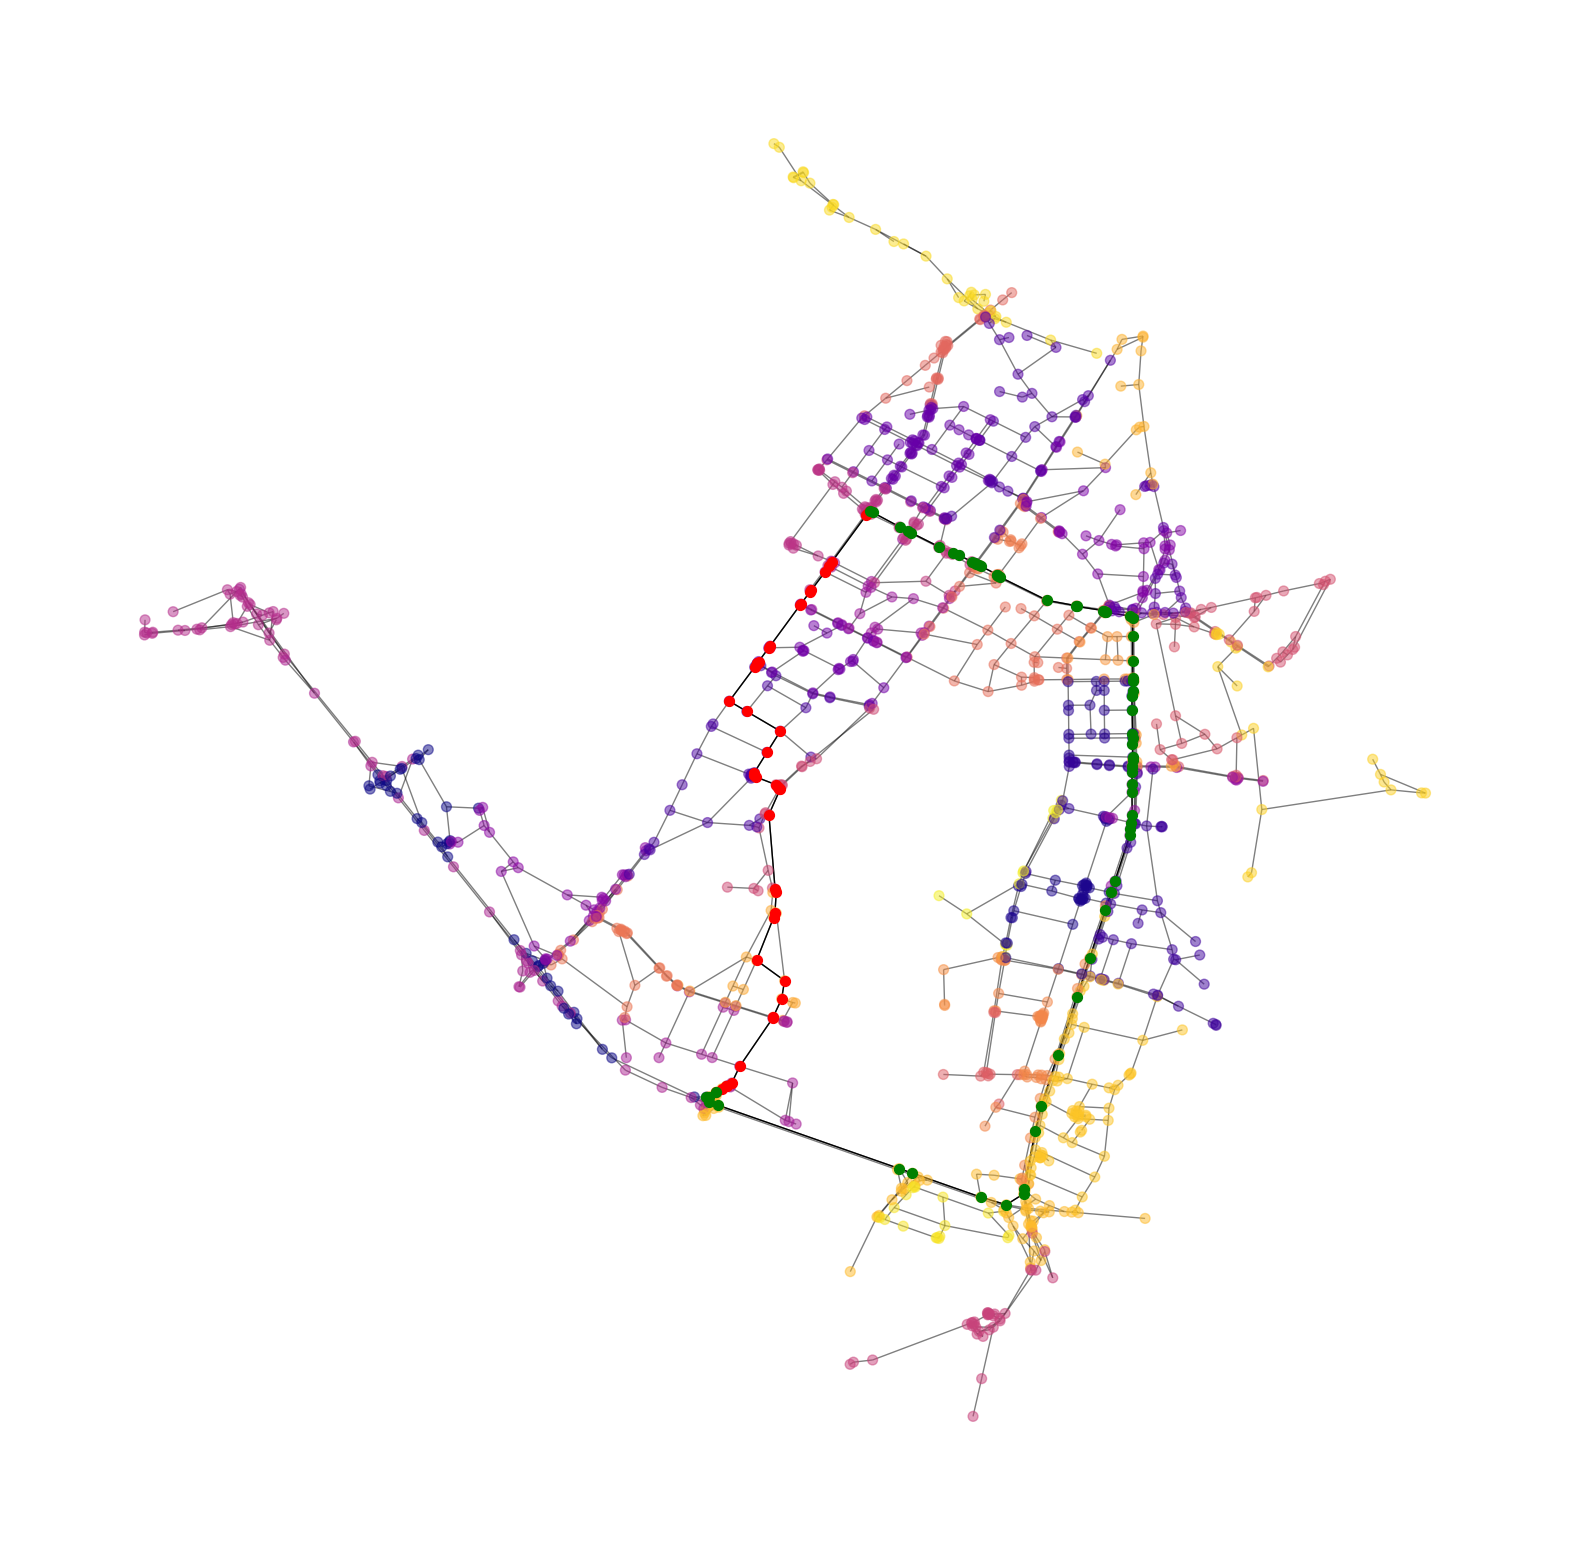

In [29]:
from matplotlib import pyplot as plt

pos_sub_graph = {u: (d['x'], d['y']) for u, d in sub_graph.nodes(data=True)}
pos_correct_path = {u: (d['x'], d['y']) for u, d in correct_path.nodes(data=True)}
pos_h_path = {u: (d['x'], d['y']) for u, d in h_path.nodes(data=True)}

# pos_G = {u: (d['x'], d['y']) for u, d in G.nodes(data=True)}

cmap = plt.get_cmap('plasma')
colors_sub_graph = [cmap(d['cluster'] / len(clusters)) for u, d in sub_graph.nodes(data=True)]

fig, axs = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(20)

nx.draw(sub_graph, ax=axs, node_size=50, pos=pos_sub_graph, alpha=0.5, node_color=colors_sub_graph)
nx.draw(correct_path, ax=axs, node_size=50, pos=pos_correct_path, node_color='red')
nx.draw(h_path, ax=axs, node_size=50, pos=pos_h_path, node_color='green')
# nx.draw(H, ax=axs,node_size = 50, pos=pos_H, node_color = 'red', edge_color = 'green')

In [ ]:
    # m = draw_on_map(sub_graph, cms)
# m.show_in_browser()